In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs
from permetrics.regression import RegressionMetric
import mplcyberpunk
plt.style.use("cyberpunk")
'''
07/04/2025plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

Codigo ejemplo con el modelo usado por Rappy
No hay una forma de uso pues el mismo es de comparación

Nota: El modelo multiplicativo es mas estable que el aditivo, sin embargo. Al ser este obtenida por una division. El mismo 
falla cuando hay ceros

'''
##########################################################
#                        Funciones
def smape(y_true, y_pred):
    """
    Calcula el SMAPE (Symmetric Mean Absolute Percentage Error)

    Parámetros:
    - y_true: valores reales (lista o array de NumPy)
    - y_pred: valores predichos (lista o array de NumPy)

    Retorna:
    - smape (%)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # denominator = (np.abs(y_true) + np.abs(y_pred))
    # diff = 2 * np.abs(y_pred - y_true)
    
    # # Evitar división por cero
    # mask = denominator != 0
    # smape_value = np.mean(diff[mask] / denominator[mask]) * 100

    evaluator = RegressionMetric(y_true, y_pred)
    return evaluator.symmetric_mean_absolute_percentage_error()
def winter_holden_linear_trend(y,train_size):
    """
    Descripción: Modelo que suaviza de forma exponencial y luego asume una tendencia lineal
    Descripción Hiperparametros:
    """

    train_y = y[:-train_size]
    test_y = y[-train_size:]
    modelo = Holt(train_y, initialization_method="estimated").fit(
        optimized=True
        )
    fcast_holt = modelo.forecast(train_size)
    return modelo,fcast_holt
def winter_holden_exponential_trend(y,train_size):
    """
    Descripción: Modelo que suaviza de forma exponencial y luego asume una tendencia exponencial
    Descripción Hiperparametros:
    """
    train_y = y[:-train_size]
    test_y = y[-train_size:]
    modelo = Holt(train_y, exponential=True, initialization_method="estimated").fit(
        optimized=True
        )
    fcast_exponential = modelo.forecast(train_size)
    return modelo,fcast_exponential
def winter_holden_aditive(y,train_size):
    """
    Descripción: Modelo que suaviza de formaq exponencial y luego asume una tendencia lineal
    Descripción Hiperparametros:
    """
    
    train_y = y[:-train_size]
    test_y = y[-train_size:]
    modelo = Holt(train_y, damped_trend=True, initialization_method="estimated").fit(
        optimized=True#damping_trend=0.98
    )
    fcast_h_additive = modelo.forecast(train_size)
    return modelo,fcast_h_additive
def winter_holden_multiplicativo(y,train_size):
    train_y = y[:-train_size]
    test_y = y[-train_size:]
    modelo= Holt(
        train_y, exponential=True, damped_trend=True, initialization_method="estimated"
    ).fit()
    fcast_h_multiplicative = modelo.forecast(train_size)
    return modelo,fcast_h_multiplicative


#                           Declaración de variables
df_datos = pd.read_csv(r"C:/Users/alanu/Documents/Proyecto_Integrador_GITHUB_28.03.2025/BaseDeDatos/DATOSLIMPIOSRAPPI.csv",encoding='latin-1')
# Obtiene las columnas necesarias para dividir el dataframe en dos: Uno de demanda y otro de stock
col_produccion_inicial = []
col_demanda = []
for i in df_datos.columns:
    if "Produccion Inicial" in i:
        col_produccion_inicial.append(i)
    if "Entregas" in i:
        col_demanda.append(i)
# Crea el DF para demanda y el DF de producción inicial
df_prueba_produccion_inicial = df_datos[col_produccion_inicial].copy()
df_prueba_produccion_inicial = df_prueba_produccion_inicial.drop(["Produccion Inicial Total"],axis= 1)
df_prueba_demanda = df_datos[col_demanda].copy()


In [22]:
df = pd.DataFrame({
    'nombre': ['Juan', 'Ana'],
    'edad': [25, 30],
    'ciudad': ['CDMX', 'GDL']
})

# Convertir a lista de diccionarios (lo que React espera)
data_list = df.to_dict(orient='records')
data_list

[{'nombre': 'Juan', 'edad': 25, 'ciudad': 'CDMX'},
 {'nombre': 'Ana', 'edad': 30, 'ciudad': 'GDL'}]

In [24]:
df_prueba_demanda.to_dict(orient='records')

[{'Entregas Black': 25834,
  'Entregas Cincita': 2005,
  'Entregas Onix': nan,
  'Entregas Cincita Reemplazo': 321,
  'Entregas Pride 2022': nan,
  'Entregas Mundial': 2192,
  'Entregas Pride Hologlam': nan,
  'Entregas Pride Colors': nan,
  'Entregas Cardlaveritas': nan,
  'Entregas Cardtrinas': nan,
  'Entregas Cardjolote White': nan,
  'Entregas Cardjolote Black': nan,
  'Entregas Ocean Plastic': nan,
  'Entregas PlayCard': nan,
  'Entregas Alebrije': nan,
  'Entregas Gotica': nan,
  'Entregas Pride 2024': nan,
  'Entregas Minion Rayo': nan,
  'Entregas Minion Mega': nan,
  'Entregas Cardlaveritas 2024': nan,
  'Entregas Wicked': nan},
 {'Entregas Black': 33271,
  'Entregas Cincita': 0,
  'Entregas Onix': nan,
  'Entregas Cincita Reemplazo': 0,
  'Entregas Pride 2022': nan,
  'Entregas Mundial': 0,
  'Entregas Pride Hologlam': nan,
  'Entregas Pride Colors': nan,
  'Entregas Cardlaveritas': nan,
  'Entregas Cardtrinas': nan,
  'Entregas Cardjolote White': nan,
  'Entregas Cardjolote

In [2]:
# Proceso para quedarse con columnas con más de 18 datos
filtro_nan = []
for i in df_prueba_demanda.columns:
    if df_prueba_demanda[i].isna().sum() <=18:
        filtro_nan.append(True)
    else:
        filtro_nan.append(False)

0.2893706534590398
0.38506143596711523
0.3575694262627405
0.3315959616126453


C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


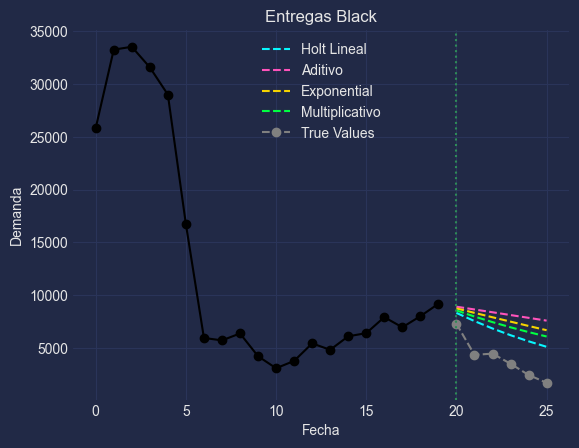

0.6135241959049794
0.658432139579717
0.6611753915472498
0.625587932551578


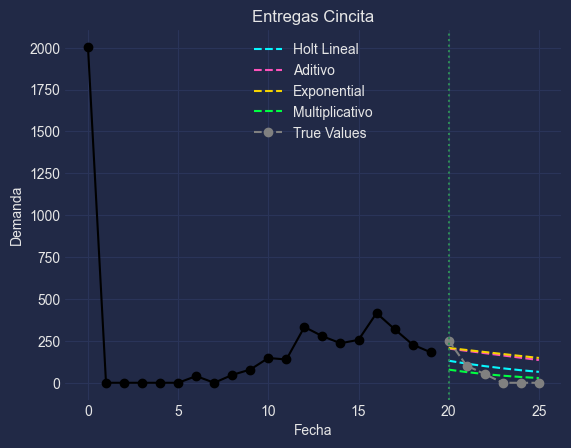

0.9959407357364971
1.0
1.0
0.9961215579030441


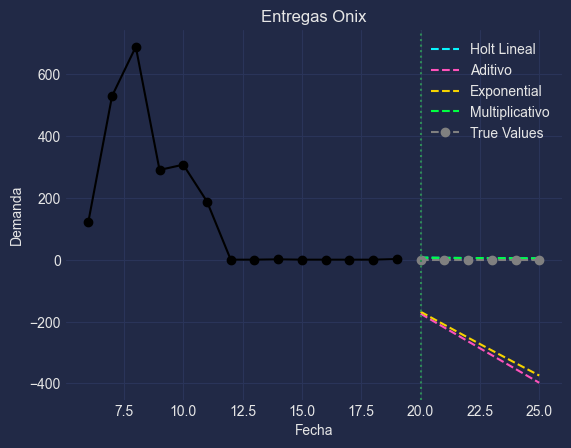

0.6261516515775659
0.6157393078375226
0.601941184170165
0.6599689823068603


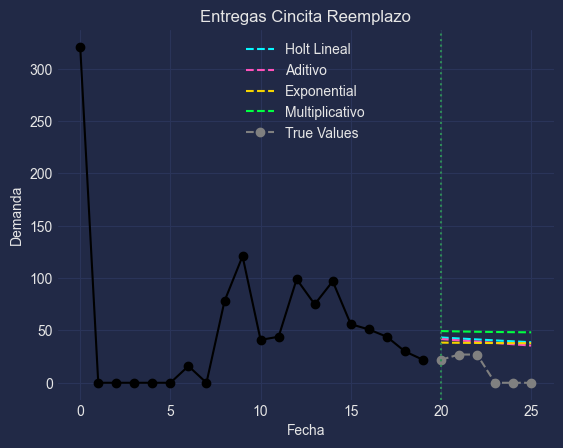

0.45056488746546614
1.0
1.0
0.936191327935207


C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


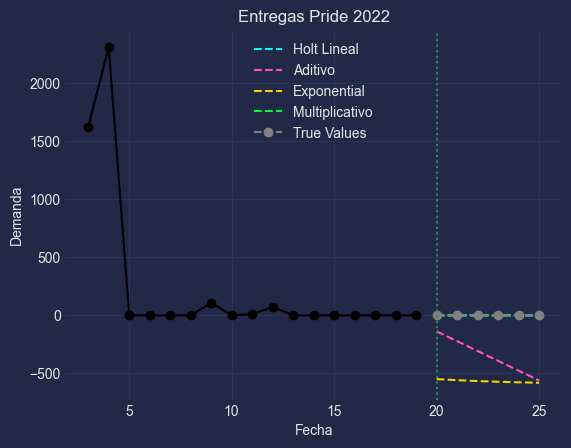

0.8839951913675725
1.0
1.0
0.9189551270463534


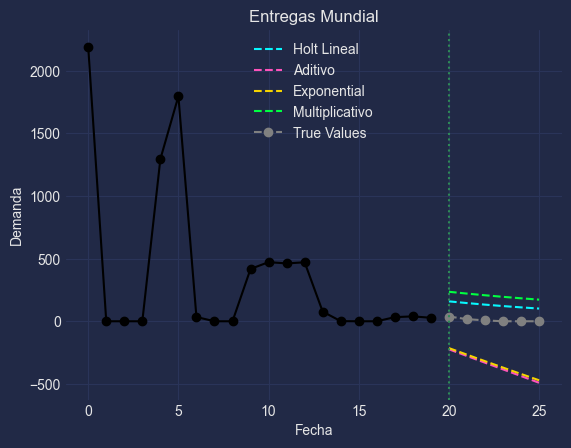

0.9375729157456968
1.0
1.0
0.9429084463320443


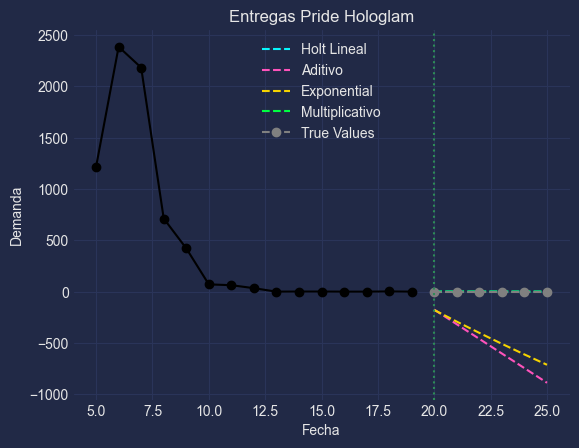

0.9509250038495756
1.0
1.0
0.9667477571824324


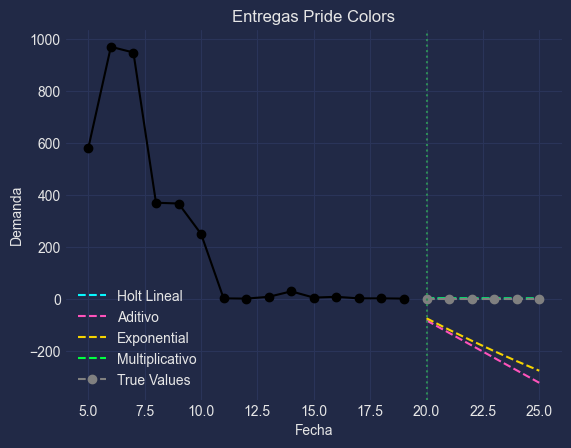

0.7175700954473682
1.0
1.0
0.635135353981505


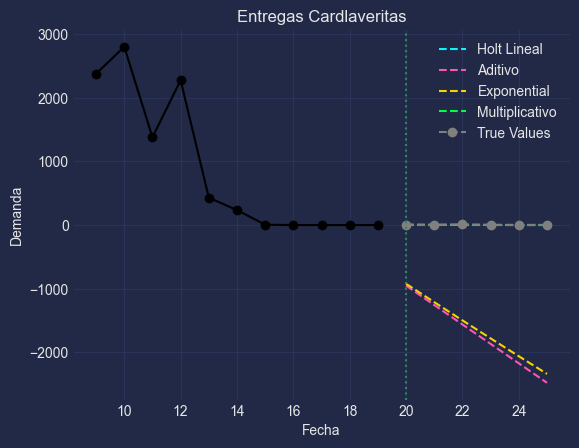

0.9180161083420227
1.0
1.0
0.9367512581389065


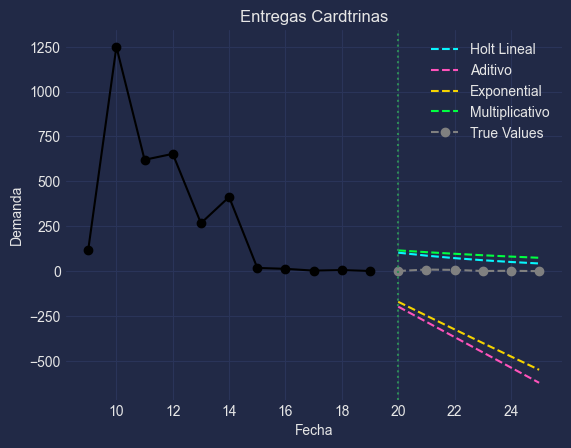

0.9468314575137401
1.0
1.0
0.9512681699496145


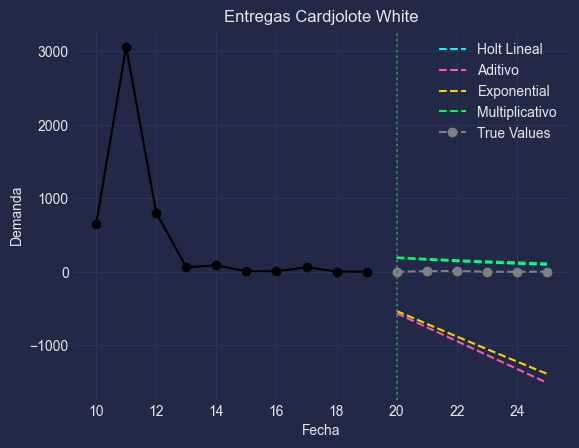

0.35444416325044087
0.8972953414443857
0.7866600230110729
0.32601870070430344


C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


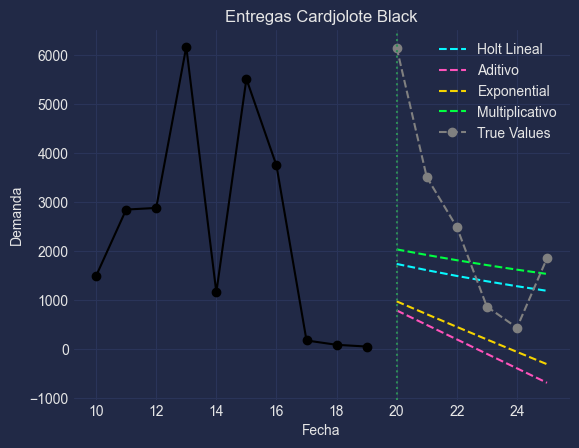

C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0.3640939880566482
0.6105940300898186
0.6457734830081955
0.3527275336512969


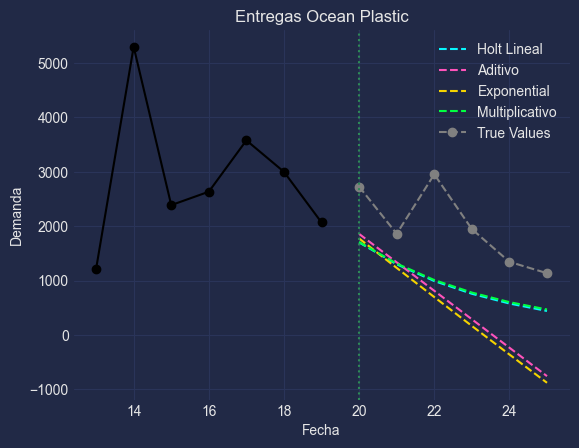

C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\alanu\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0.46526194717415265
0.6066364061455907
0.6305468514722629
0.46540370433994727


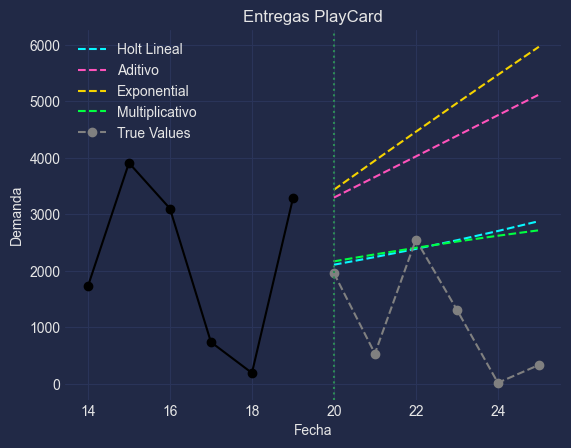

0.7348074535264976
0.7926138089470879
0.8412745263706891
0.7434383393778766


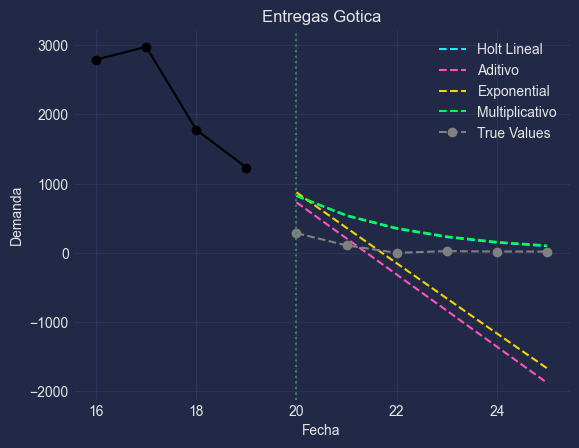

0.9489412539876644
0.939622015748362
0.9394367022837974
0.9421248152729887


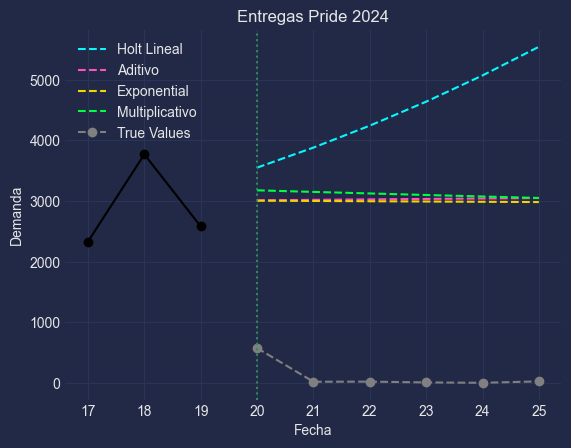

0.411818260040752
0.6886730557214037
0.6925860563485681
0.47341589036729337


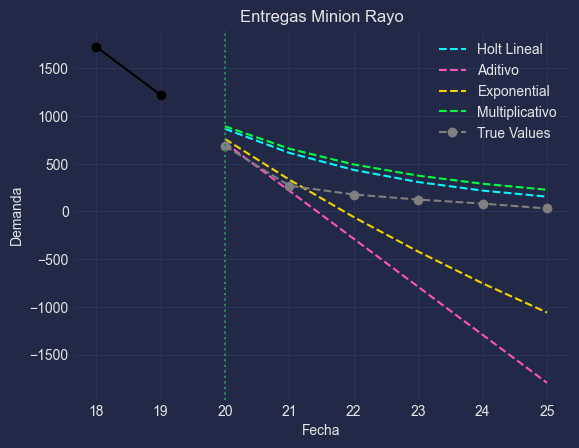

0.4517180493746685
0.7894702998941442
0.7851241080333722
0.48599375568225334


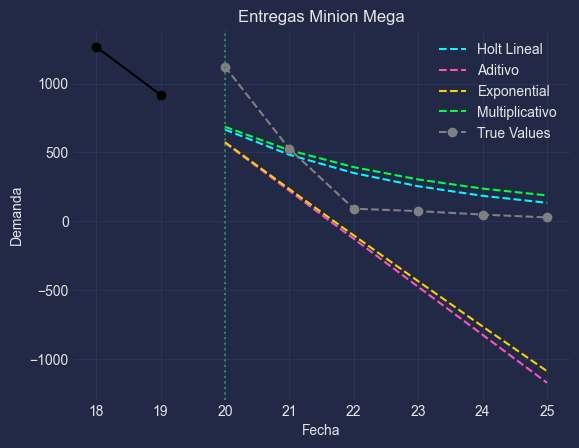

In [3]:
test_size = 6
# Modelo
label_modelos = ["Holt Lineal","Aditivo","Exponential","Multiplicativo"]
functions_modelos = [winter_holden_exponential_trend,winter_holden_linear_trend,winter_holden_aditive,winter_holden_multiplicativo]
l_df_metricas = [pd.DataFrame()]*4
l_df_resul = [pd.DataFrame()]*4
for col in df_prueba_demanda.T[filtro_nan].T:

    # Workaround: Para que se mantenga estrictamente positivo
    aux_series = pd.Series(np.where(df_prueba_demanda[col] == 0,0.01,df_prueba_demanda[col]))
    # Determina cuando inicio la producción.
    j = 1
    inicio_pord = 0
    for i in aux_series.isna()[:-1]:
        if i != aux_series.isna()[j] and i :
            inicio_pord = j
            continue
        j+=1
    aux_series = aux_series[inicio_pord:]
    # Modelos
    # Gráfica de Matplitlibt
    plt.figure()
    # mplcyberpunk.make_lines_glow()
    plt.plot(aux_series[:-test_size],marker = "o",color = "black")
    # mplcyberpunk.add_glow_effects()
    num = 0
    for fun,etiqueta in zip(functions_modelos,label_modelos):
        modelo_,fcast_ = fun(aux_series,test_size)
        aux_series_resul = pd.concat([modelo_.fittedvalues,fcast_])
        l_df_resul[num][col] = aux_series_resul
        l_df_metricas[num][col] = [smape(fcast_,aux_series[-test_size:]),meanabs(fcast_,aux_series[-test_size:])]
        print(smape(aux_series[-test_size:], fcast_) )
        plt.plot(fcast_,linestyle = "--",label = etiqueta)
        num +=1
    
    # aux = modelo_multiplicativo.fittedvalues
    # plt.plot(aux,linestyle = ":",marker = "o")
    plt.plot(aux_series[-test_size:],marker = "o",linestyle = "--",color = "gray",label = "True Values")
   
    plt.axvline(20,linestyle = ":",color = "seagreen")
    
    plt.title(f"{col}")
    plt.ylabel("Demanda")
    plt.xlabel("Fecha")
    plt.legend()
    plt.show()


In [11]:
for num,df in enumerate(l_df_metricas):
    ruta =  fr"C:\Users\alanu\Documents\Proyecto_Integrador_GITHUB_28.03.2025\BaseDeDatos\{label_modelos[num]}_metricas.xlsx"

    df.reindex(["SMAPE","MAE"]).to_excel(ruta)

In [ ]:
#import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
def KPSS_TEST(x,tipo_regresion = "c"):
    """
    OBJETIVO: Probar estacionaridad.
    Es decir que la media, varianza y covarianza no cambia con el tiempo.
    Osea media constante, que la dispersion de los datos se mantiene constante y que la relacién entre ambas variales igual se mantiene
    constante a lo largo del tiempo.
    Si la serie tiene una raiz unitaria IMPLICA no es estacionaria. Esto prueba es para probar eso
    H0 = La serie es estacionaria.
    
    Si la estadistica es menor al valor critico, entonces se acepta( eso es con el nivel de significancia de 0.05)
    Pvalue: La probabilidad de obtener ese resultado
    Si pvalue < nivel de sifnificancia(0.05), me ando inventando unicornios y por tanto no sirve


    Es decir esta cosa es para hacer prueba de hipotesis
            REQUERIMIENTOS
    Ocupas que los errores de tu serie no esten correlacionados
            HIPERPARAMETROS

    NLAGS: Los errores se pueden ir acumulado desde n pasos atras, para eso vas checando el lag
    El auto pues estaditicamente te dice cómo cuantos ocupas
    Regression = c estacionaria respecto a una constante, ct estancionaria respecto a una tendencia

    

    TO DO----------------------
    Caso 3: KPSS indica estacionariedad y ADF indica no estacionariedad. La serie es estacionaria en la tendencia. Es necesario eliminar la tendencia para que la serie sea estrictamente estacionaria. Se verifica la estacionariedad de la serie sin tendencia.
    Caso 4: KPSS indica no estacionariedad y ADF indica estacionariedad. La serie es estacionaria en diferencias. Se utiliza la diferenciación para que la serie sea estacionaria. Se verifica la estacionariedad de la serie diferenciada.

    """
    estadistica_prueba,pvalue,lags,resul=kpss(x,regression=tipo_regresion,nlags="auto")
    aux_series = pd.Series(np.array(list(resul.values())) <estadistica_prueba,index=resul.keys())
    aux_series["pvalue"] = pvalue >0.015
    aux_series["#Lags"] = lags
    return aux_series
def shapiro_test(df):
    """ 
    Prueba de normalidad usada cuando hay menos de 50 datos
    Objetivo. Si el estadistico se acerca a 1 se aceerca a una normal
    Pvalue. "Confianza de la prueba"
    Estoy poniendo los true si es que se acepta la H0, y false si se rechaza

    """
    statistic,pvalue=shapiro(df)
    return pd.Series([statistic>0.7,pvalue>0.05],index=["Normalidad","pvalue"])

In [ ]:
df_kpss = pd.DataFrame()
df_normalidad_shapiro = pd.DataFrame()
for col in df_prueba_demanda.columns:
        # Workaround: Para que se mantenga estrictamente positivo
    aux_series = pd.Series(np.where(df_prueba_demanda[col] == 0,0.01,df_prueba_demanda[col]))
    # Determina cuando inicio la producción.
    j = 1
    inicio_pord = 0
    for i in aux_series.isna()[:-1]:
        if i != aux_series.isna()[j] and i :
            inicio_pord = j
            continue
        j+=1
    aux_series = aux_series[inicio_pord:]
    df_kpss[col] = KPSS_TEST(aux_series,"c")
    df_normalidad_shapiro[col] = shapiro_test(aux_series)

C:\Users\alanu\AppData\Local\Temp\ipykernel_15120\3628741596.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  estadistica_prueba,pvalue,lags,resul=kpss(x,regression=tipo_regresion,nlags="auto")
C:\Users\alanu\AppData\Local\Temp\ipykernel_15120\3628741596.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  estadistica_prueba,pvalue,lags,resul=kpss(x,regression=tipo_regresion,nlags="auto")
C:\Users\alanu\AppData\Local\Temp\ipykernel_15120\3628741596.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  estadistica_prueba,pvalue,lags,resul=kpss(x,regression=tipo_regresion,nlags="auto")
C:\Users\alanu\AppData\Local\Temp\ipy

In [ ]:
# Función para aplicar estilos
def colorize(val):
    if type(val) != int:
        color = 'seagreen' if val else 'salmon'
        return f'background-color: {color}'
    else:
        return ""

# Aplicar estilo
df_kpss.style.applymap(colorize)




C:\Users\alanu\AppData\Local\Temp\ipykernel_15120\530599628.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_kpss.style.applymap(colorize)


,Entregas Black,Entregas Cincita,Entregas Onix,Entregas Cincita Reemplazo,Entregas Pride 2022,Entregas Mundial,Entregas Pride Hologlam,Entregas Pride Colors,Entregas Cardlaveritas,Entregas Cardtrinas,Entregas Cardjolote White,Entregas Cardjolote Black,Entregas Ocean Plastic,Entregas PlayCard,Entregas Alebrije,Entregas Gotica,Entregas Pride 2024,Entregas Minion Rayo,Entregas Minion Mega,Entregas Cardlaveritas 2024,Entregas Wicked
10%,True,False,True,False,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,False,False
5%,True,False,True,False,False,True,False,True,True,True,False,False,False,False,True,True,False,False,False,False,False
2.5%,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1%,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pvalue,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
#Lags,3,0,2,0,1,1,2,2,2,1,1,0,1,0,2,1,1,1,1,1,0


In [ ]:
df_normalidad_shapiro.style.applymap(colorize)

C:\Users\alanu\AppData\Local\Temp\ipykernel_15120\986528337.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_normalidad_shapiro.style.applymap(colorize)


,Entregas Black,Entregas Cincita,Entregas Onix,Entregas Cincita Reemplazo,Entregas Pride 2022,Entregas Mundial,Entregas Pride Hologlam,Entregas Pride Colors,Entregas Cardlaveritas,Entregas Cardtrinas,Entregas Cardjolote White,Entregas Cardjolote Black,Entregas Ocean Plastic,Entregas PlayCard,Entregas Alebrije,Entregas Gotica,Entregas Pride 2024,Entregas Minion Rayo,Entregas Minion Mega,Entregas Cardlaveritas 2024,Entregas Wicked
Normalidad,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
pvalue,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True


In [ ]:
# results = pd.DataFrame(
#     index=[r"Smoothing level $\alpha$ ", r" Trend $\beta$", r" Damping $\phi$", r"$l_0$", "$b_0$", "MSE"],
#     columns=[ "Holt's", "Exponential", "Additive", "Multiplicative"],
# )
# results["Holt's"] = [train_set_demanda_black_holt.params[p] for p in params] + [smape(train_set_demanda_black_holt.fittedvalues,train_set_demanda_black["Demanda_Black"])]
# results["Exponential"] = [train_set_demanda_black_exponential.params[p] for p in params] + [smape(train_set_demanda_black_exponential.fittedvalues,train_set_demanda_black["Demanda_Black"])]
# results["Additive"] = [train_set_demanda_holt_addtive.params[p] for p in params] + [smape(train_set_demanda_holt_addtive.fittedvalues,train_set_demanda_black["Demanda_Black"])]
# results["Multiplicative"] = [train_set_demanda_holt_multiplicative.params[p] for p in params]+ [smape(train_set_demanda_holt_multiplicative.fittedvalues,train_set_demanda_black["Demanda_Black"])]
# results

In [ ]:
df_prueba_demanda = df_prueba_demanda[sorted(df_prueba_demanda.columns)]
df_prueba_produccion_inicial = df_prueba_produccion_inicial[sorted(df_prueba_produccion_inicial.columns)]

In [ ]:
tarjetas = [i[9:] for i in df_prueba_demanda.columns]
df_prueba_delta = pd.DataFrame()

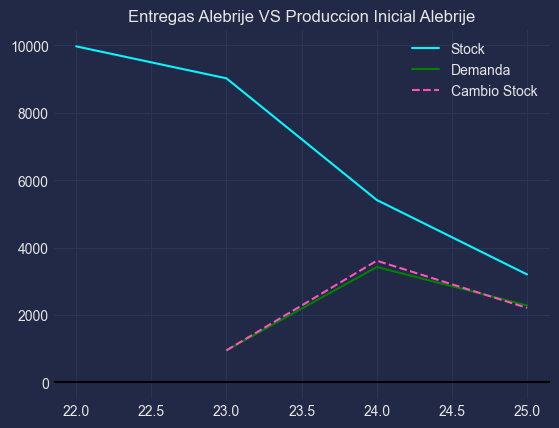

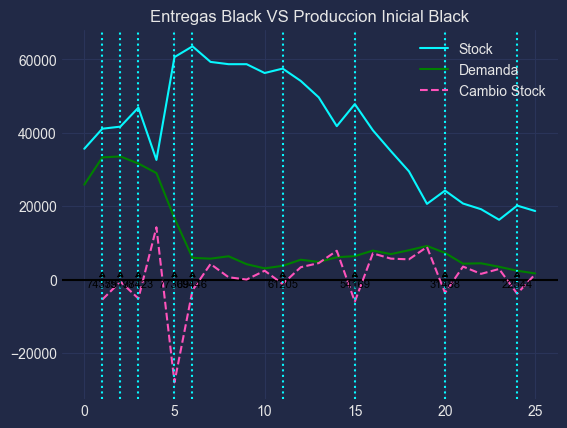

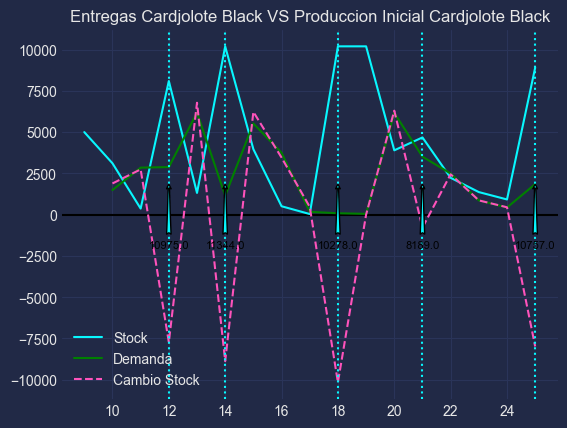

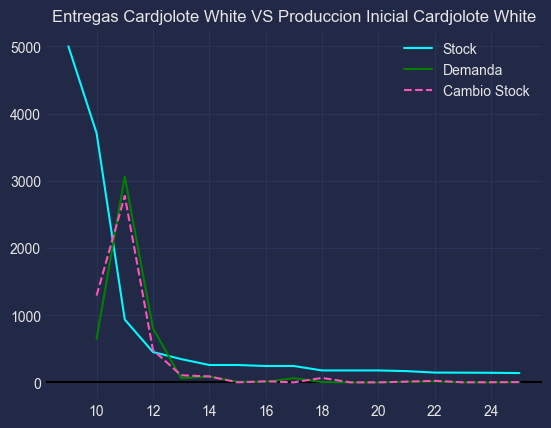

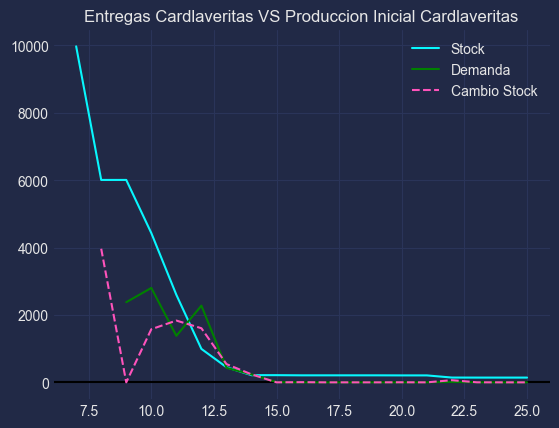

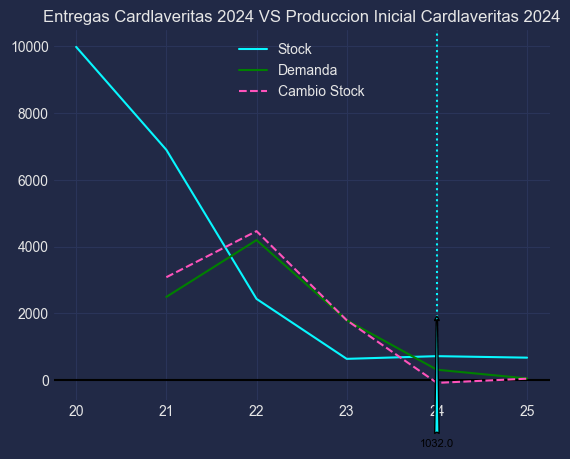

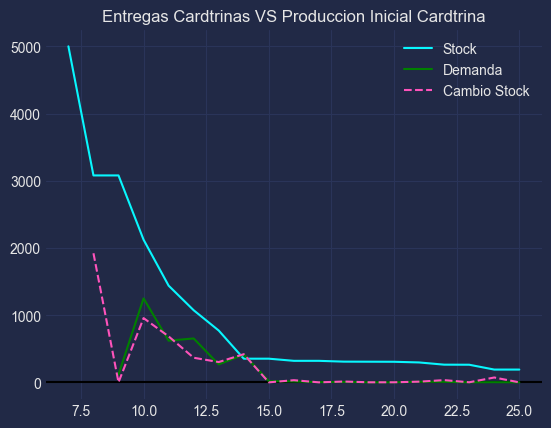

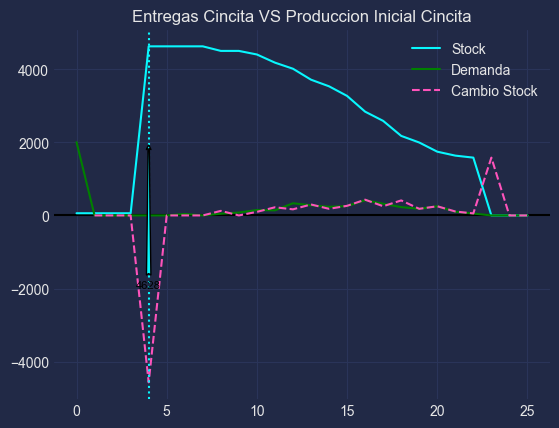

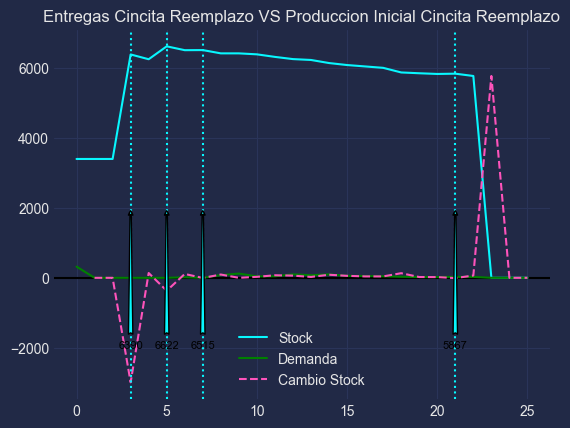

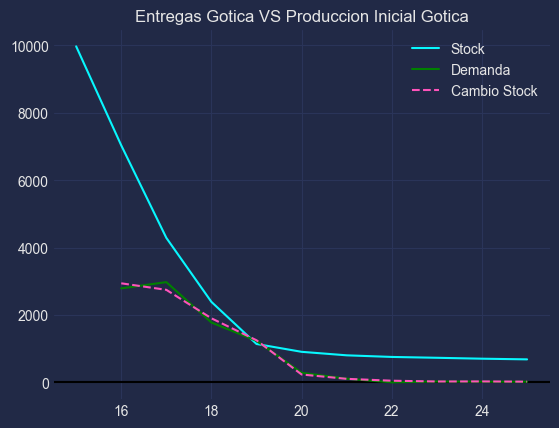

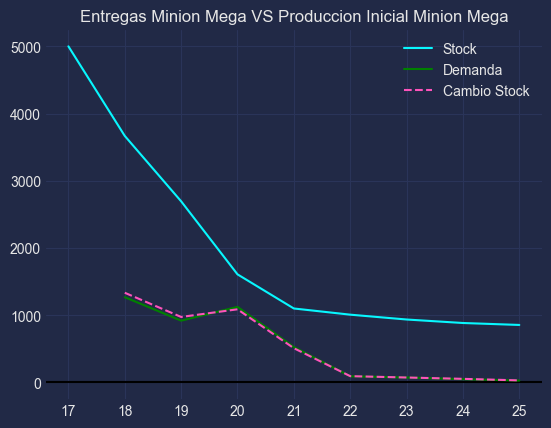

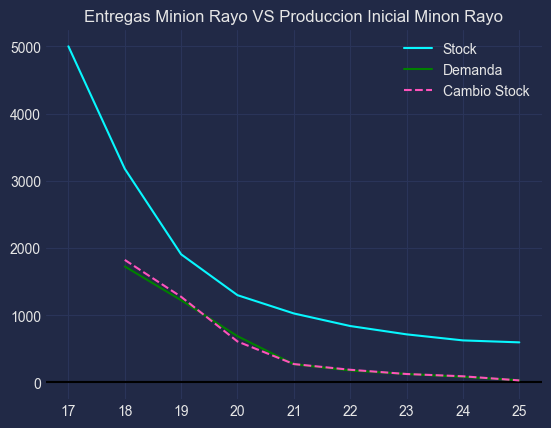

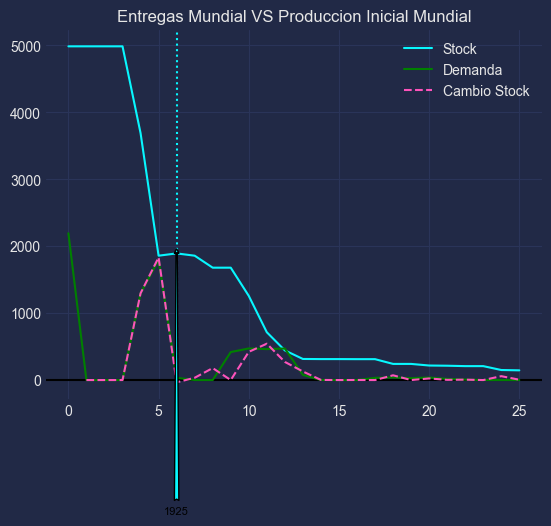

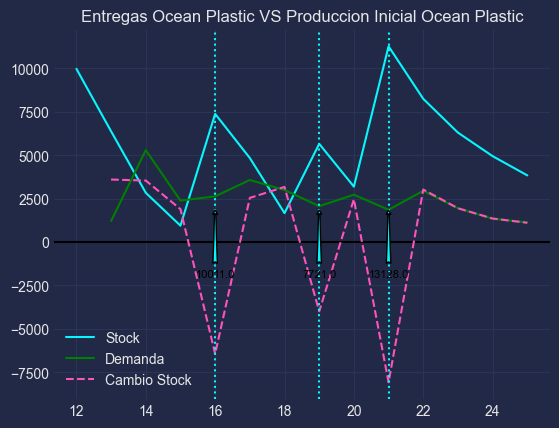

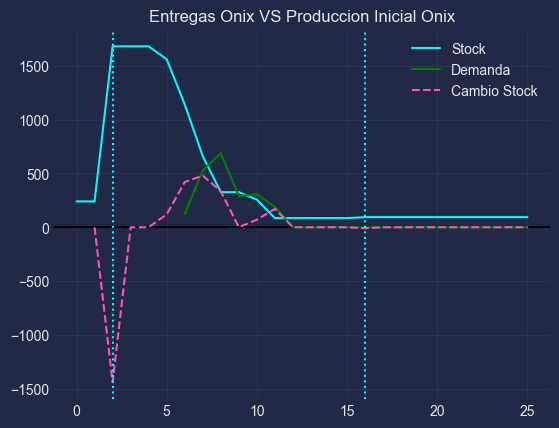

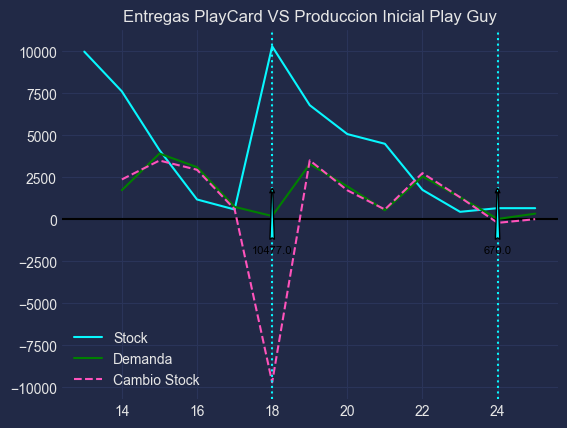

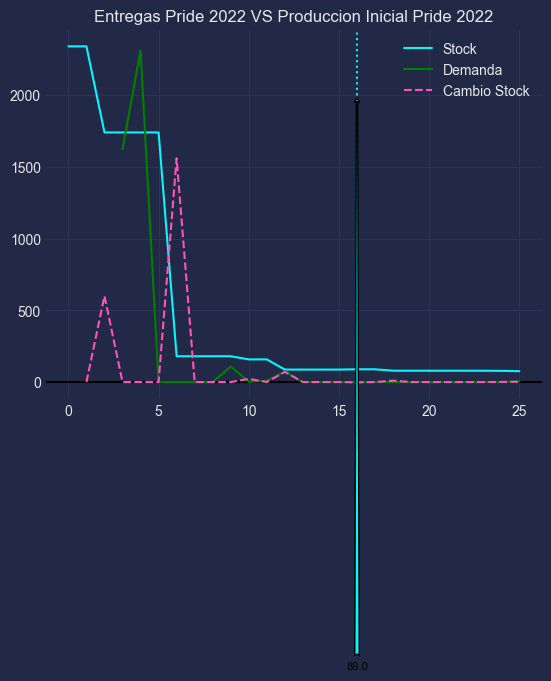

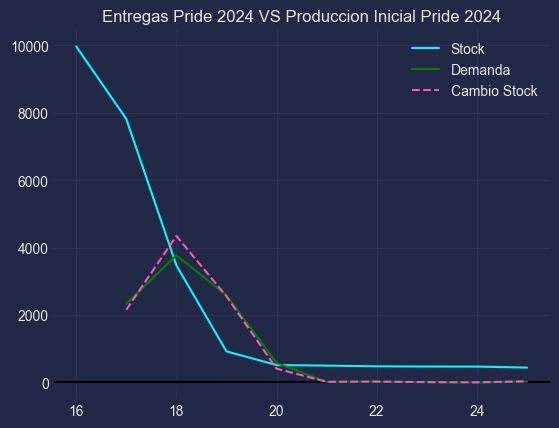

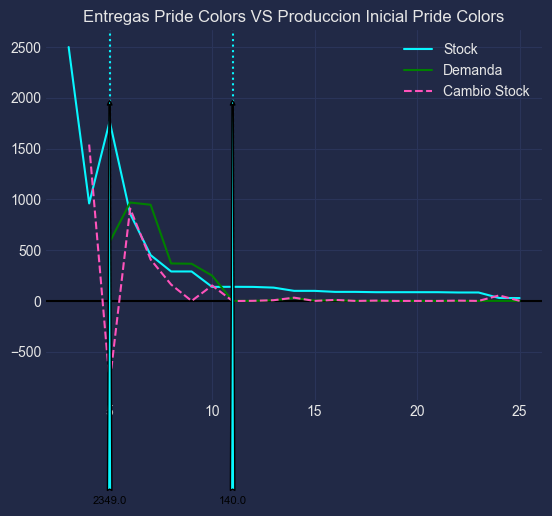

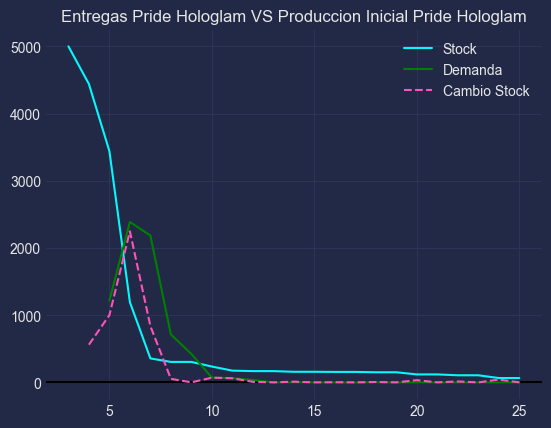

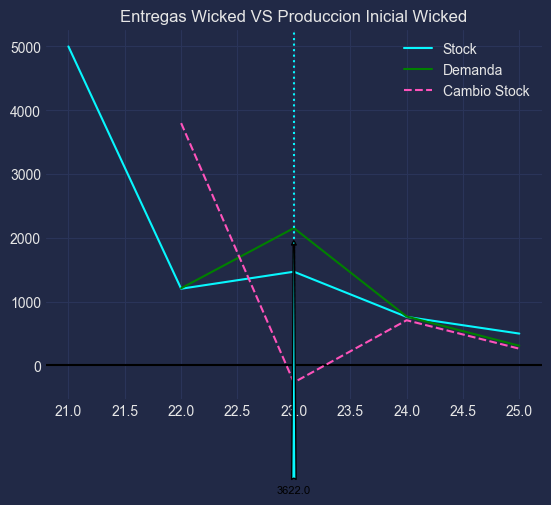

In [ ]:
num = 0
for i,j in zip(df_prueba_demanda.columns,df_prueba_produccion_inicial.columns):
    cambio_stock = [np.nan]*26
    for k in range(1,len(df_prueba_produccion_inicial[j])):
        val_ant = df_prueba_produccion_inicial[j][k-1]
        cambio_stock[k] = val_ant -df_prueba_produccion_inicial[j][k]  #ANTERIO - SIGUIENTE CON EL INDICE ACTUAL
    df_prueba_delta["Cambio Stock" + tarjetas[num]] = cambio_stock
    df_aux = pd.DataFrame(cambio_stock)
    filtro_aux = np.array(cambio_stock) <0
    posicion_asintotas = df_aux[filtro_aux].index
    produccion_asintotas =  df_prueba_produccion_inicial[j][filtro_aux] + df_prueba_demanda[i][filtro_aux]
    plt.figure()
    plt.axhline(0, color = "black")
    plt.plot(df_prueba_produccion_inicial[j], label= "Stock")
    plt.plot(df_prueba_demanda[i], color = "green",label = "Demanda")
    plt.plot(cambio_stock, linestyle = "--",label = "Cambio Stock")
    for asintota,produccion in zip(posicion_asintotas,produccion_asintotas):
        plt.axvline(asintota,linestyle = ":")
        plt.annotate(f"{produccion}",
                xy=(asintota,2000),
                xytext=(asintota,-2000),
                arrowprops=dict(arrowstyle = "fancy"),#,shrink=0.05, width=2, headwidth=8
                ha='center', color='black',fontsize = 8)
    plt.legend()
    plt.title(i +" VS "+ j)
    plt.show()
    num +=1

    # del aux_filtro
# El batch inicial ni si quieras es creado por una demanda pronosticada para los proximos 6 mersses que son los que tienen que cubrir 
#sin eso, son solo multiplos de 2500
# Batches de menos de 100 no se vuelven a producir
# La curva de demanda, muestra pues las entregas hechas el mes pasado
# En general cada que la demanda del siguiente mes estima que lleva el inventario menos de 0 generan un nuevo batch
# Lo raro es que no lo hacen en 6 meses como es de esperarse.
# Para saber el impulso positivo
# Pues en mi punto actual = stock-demanda + PI = cambio_stock 

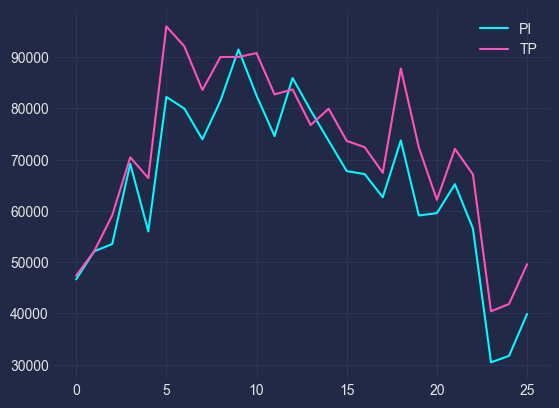

In [ ]:
plt.figure()
plt.plot(df_datos["Produccion Inicial Total"],label = "PI")
plt.plot(df_datos["Stocks Tarjetas Personalizadas"],label = "TP")
plt.legend()
plt.show()

In [ ]:
cambio_CB = [np.nan]*len(df_datos["Stocks Cardbody Black"])
for i in range(1,len(df_datos["Stocks Cardbody Black"])):
    cambio_CB[i] = df_datos["Stocks Cardbody Black"][i-1]-df_datos["Stocks Cardbody Black"][i]

In [ ]:
df_aux = pd.DataFrame(cambio_CB)
index = np.where(df_aux <0)
# index = df_aux[filtro].index

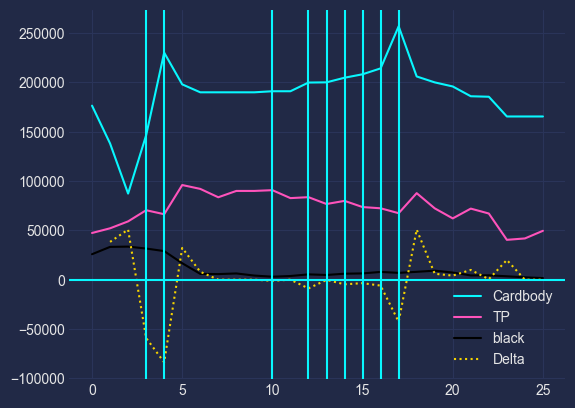

In [ ]:
plt.figure()
plt.plot(df_datos["Stocks Cardbody Black"],label = "Cardbody")
plt.plot(df_datos["Stocks Tarjetas Personalizadas"],label = "TP")
plt.plot(df_datos["Entregas Black"],label = "black", color = "Black")
plt.plot(np.array(cambio_CB),linestyle = ":", label = "Delta")
for i in index[0]:
    plt.axvline(i)
plt.axhline(0)
plt.legend()
plt.show()

In [ ]:
df_prueba_entregas_mundial = pd.DataFrame()
df_prueba_entregas_mundial["Demanda Mundial"] = df_prueba_demanda["Entregas Mundial"]
df_prueba_entregas_mundial["PI Mundial"] = df_prueba_produccion_inicial["Produccion Inicial Mundial"]

In [ ]:
df_prueba_entregas_mundial

val_ant = df_prueba_entregas_mundial["PI Mundial"][1]
cambio_stock = [0]*26
for i in range(1,len(df_prueba_entregas_mundial["PI Mundial"])):
    val_ant = df_prueba_entregas_mundial["PI Mundial"][i-1]
    cambio_stock[i-1] = val_ant - df_prueba_entregas_mundial["PI Mundial"][i]
df_prueba_entregas_mundial["Cambio Stock"] = cambio_stock

Demanda Mundial
PI Mundial
Cambio Stock


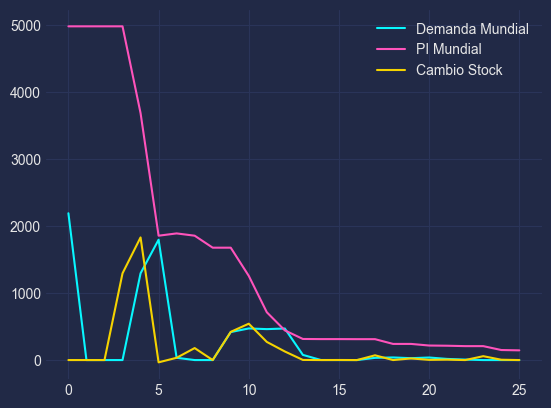

In [ ]:

plt.figure()
for i in df_prueba_entregas_mundial.columns:
    print(i)
    plt.plot(df_prueba_entregas_mundial[i],label = i)
plt.legend()